# Clean With IR

## 1. Make the mesh

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gmsh
from dolfinx import fem
import pandas as pd
import numpy as np

from mesh_and_materials.mesh import *
from mesh_and_materials.materials import *
from space.space_and_forms import *
from dirichlet_bc.bc import *

In [3]:
# Sample geometry (all units in meters)

d_ins_oside = 6.3e-6
d_ins_pside = 3.2e-6
d_sample    = 1.84e-6
d_ir        = 0.062e-6
d_diam      = 40e-6

y_sample    = 20e-6
y_gasket   = 75e-6
y_ins_gside = 5e-6

# Mesh bounds
x_length = d_ins_oside + d_ins_pside + d_sample + 2 * d_ir
mesh_xmin, mesh_xmax = -(x_length/2), x_length/2

y_length = y_sample + y_gasket + y_ins_gside
mesh_ymin, mesh_ymax = -y_length, 0.0

# mesh file name
mesh_name = 'with_gask'


In [4]:

# Material 

# pside diamond
bx_diam_pside = mesh_xmin
BX_diam_pside = mesh_xmin + d_diam
by_diam_pside = mesh_ymin
BY_diam_pside = mesh_ymax

# pside coupler-adj insulator
bx_ins_pside = BX_diam_pside
BX_ins_pside = bx_ins_pside + d_ins_pside
by_ins_pside = mesh_ymin + y_gasket + y_ins_gside
BY_ins_pside = mesh_ymax

# pside coupler
bx_ir_pside  = BX_ins_pside
BX_ir_pside  = bx_ir_pside + d_ir
by_ir_pside  = by_ins_pside
BY_ir_pside  = BY_ins_pside

# sample
bx_sample    = BX_ir_pside
BX_sample    = bx_sample + d_sample
by_sample    = by_ins_pside
BY_sample    = BY_ins_pside 

# oside coupler
bx_ir_oside  = BX_sample
BX_ir_oside  = bx_ir_oside + d_ir
by_ir_oside  = by_ins_pside
BY_ir_oside  = BY_ins_pside

# oside coupler-adj insulator
bx_ins_oside = BX_ir_oside
BX_ins_oside = bx_ins_oside + d_ins_oside
by_ins_oside = by_ins_pside
BY_ins_oside = BY_ins_pside

# oside diamond
bx_diam_oside = BX_ins_oside
BX_diam_oside = bx_diam_oside + d_diam
by_diam_osde  = mesh_ymin
BY_diam_oside = mesh_ymax

# gasket-adj insulator
bx_ins_gside  = BX_diam_pside
BX_ins_gside  = bx_diam_oside
by_ins_gside  = mesh_ymin + y_gasket
BY_ins_gside  = by_ins_gside + y_ins_gside   

# gasket
bx_gasket     = BX_diam_pside
BX_gasket     = bx_diam_oside
by_gasket     = mesh_ymin
BY_gasket     = mesh_ymin + y_gasket


# pside diamond
pside_diamond = Material(
    "pside diamond",  # Diamond jacket on the pulsed side
    boundaries=[bx_diam_pside, BX_diam_pside, by_diam_pside, BY_diam_pside],
    properties={"rho_cv": 3500 * 510, "k": 2000},
    mesh_size=1e-6  # 1 μm
)

# pside ins
ins_pside = Material(
    "pside ins",
    boundaries=[bx_ins_pside, BX_ins_pside, by_ins_pside, BY_ins_pside],
    properties={"rho_cv": 4131 * 668, "k": 10},
    mesh_size=0.1e-6
)

# pside ir
ir_pside = Material(
    "pside ir",
    boundaries=[bx_ir_pside, BX_ir_pside, by_ir_pside, BY_ir_pside],
    properties={"rho_cv": 26504 * 130, "k": 352},
    mesh_size=0.02e-6
)

# sample
sample = Material(
    "sample",
    boundaries=[bx_sample, BX_sample, by_sample, BY_sample],
    properties={"rho_cv": 5164 * 1158, "k": 3.9},
    mesh_size=0.08e-6
)

# oside ir
ir_oside = Material(
    "oside ir",
    boundaries=[bx_ir_oside, BX_ir_oside, by_ir_oside, BY_ir_oside],
    properties={"rho_cv": 26504 * 130, "k": 352},
    mesh_size=0.02e-6
)

# oside ins
ins_oside = Material(
    "oside ins",
    boundaries=[bx_ins_oside, BX_ins_oside, by_ins_oside, BY_ins_oside],
    properties={"rho_cv": 4131 * 668, "k": 10},
    mesh_size=0.1e-6
)

# oside diamond
diam_oside = Material(
    "oside diamond",  # Diamond jacket on the opposite side
    boundaries=[bx_diam_oside, BX_diam_oside, by_diam_osde, BY_diam_oside],
    properties={"rho_cv": 3500 * 510, "k": 2000},  # ρ·cᵥ=1.79e6 J/(m³·K), k=1500 W/(m·K)
    mesh_size=1e-6
)

# gasket-adj insulator
ins_gside = Material(
    "gside ins",
    boundaries=[bx_ins_gside, BX_ins_gside, by_ins_gside, BY_ins_gside],
    properties={"rho_cv": 4131 * 668, "k": 10},
    mesh_size=0.1e-6
)

# gasket
gasket = Material(
    "gasket",  # Rhenium pressure gasket
    boundaries=[bx_gasket, BX_gasket, by_gasket, BY_gasket],
    properties={"rho_cv": 21000 * 140, "k": 100},  # ρ·cᵥ=2.88e6 J/(m³·K), k=100 W/(m·K)
    mesh_size=1e-6  # 1 μm
)

materials = [
    pside_diamond,
    ins_pside,
    ir_pside,
    sample,
    ir_oside,
    ins_oside,
    diam_oside,
    ins_gside,
    gasket
]

gmsh_domain = Mesh(
    name=mesh_name,
    boundaries=[mesh_xmin, mesh_xmax, mesh_ymin, mesh_ymax],
    materials=materials
)




In [5]:
gmsh_domain.build_mesh()

no mesh errors found
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 13 (Line)
Info    : [ 40%] Meshing curve 14 (Line)
Info    : [ 50%] Meshing curve 15 (Line)
Info    : [ 50%] Meshing curve 17 (Line)
Info    : [ 50%] Meshing curve 18 (Line)
Info    : [ 60%] Meshing curve 19 (Line)
Info    : [ 60%] Meshing curve 21 (Line)
Info    : [ 60%] Meshing curve 22 (Line)
Info    : [ 70%] Meshing curve 23 (Line)
Info    : [ 70%] Meshing curve 25 (Line)
Info    : [ 70%] Meshing curve 26 (Line)
Info    : [ 80%] Meshing curve 27 (Line)
Info    : [ 80%] Mesh

In [6]:
gmsh_domain.write(mesh_name + '.msh')
# Visualize in gmsh if desired
gmsh.open(mesh_name + '.msh')
gmsh.fltk.initialize()
gmsh.fltk.run()

Info    : Writing 'with_gask.msh'...
Info    : Done writing 'with_gask.msh'
Info    : Reading 'with_gask.msh'...
Info    : 60 entities
Info    : 233621 nodes
Info    : 465156 elements                                                                                     
Info    : Done reading 'with_gask.msh'                                                                           
-------------------------------------------------------
Version       : 4.13.1
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20240524
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] LinuxJoystick MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen Nii2mesh ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR TinyXML2[contrib] Unt

In [7]:
gmsh.finalize()

## 2. Run the simulation

In [8]:
df = pd.read_csv('experimental_data/raw_temp_time_curve.csv')
df_exact = df.copy().reset_index(drop=True)
df_exact.columns = ['time', 'pside temperature', 'oside temperature']

df_exact = (df_exact
            .apply(pd.to_numeric)
            .dropna()
            .sort_values('time')
            .reset_index(drop=True))

df_exact['pside normed'] = (df_exact['pside temperature'] - df_exact['pside temperature'].iloc[0]) / (max(df_exact['pside temperature']) - min(df_exact['pside temperature']))
df_exact['oside normed'] = (df_exact['oside temperature'] - df_exact['oside temperature'].iloc[0]) / (max(df_exact['pside temperature']) - min(df_exact['pside temperature']))
df_exact['time'] = df_exact['time'] * 10**-6  # Convert to seconds

In [9]:
import os
rebuild_mesh = False
mesh_file = 'with_gask.msh'
if not os.path.exists(mesh_file) or rebuild_mesh:
    gmsh_domain.build_mesh()
    gmsh_domain.write(mesh_file)

dolfinx_domain = Mesh.msh_to_dolfinx(mesh_file)


Info    : Reading 'with_gask.msh'...
Info    : 60 entities
Info    : 233621 nodes
Info    : 465156 elements                                                                                     
Info    : Done reading 'with_gask.msh'                                                                           


In [10]:

spaces = Space(dolfinx_domain, V_family='Lagrange', V_degree=1, Q_family='DG', Q_degree=0)

rho_cv_fxn = spaces.assign_material_property(materials, 'rho_cv')
k_fxn = spaces.assign_material_property(materials, 'k')


In [11]:
ic_temp = 300.0
ic_fxn = spaces.initial_condition(ic_temp)
u_n = fem.Function(spaces.V)
u_n.x.array[:] = ic_fxn.x.array
u_n.x.scatter_forward()


In [12]:

pside_heating_interp = lambda t: np.interp(t, 
                                           df_exact['time'], 
                                           df_exact['pside temperature'], 
                                           left=df_exact['pside temperature'].iloc[0],
                                           right=df_exact['pside temperature'].iloc[-1])

offset = df_exact['pside temperature'].iloc[0] - ic_temp
def heating_offset(t):
    return float(pside_heating_interp(t)) - offset


In [13]:

# Gaussian profile for inner boundary
heating_FWHM = 13.2e-6
coeff = -4.0 * np.log(2.0) / heating_FWHM**2
y_center = 0.0

def gaussian(x, y, t):
    amp = heating_offset(t)
    return (amp - ic_temp) * np.exp(coeff * (y - y_center)**2)*0.5 + ic_temp

bcs = []
left_bc = RowDirichletBC(spaces.V, 'left', value=ic_temp)
right_bc = RowDirichletBC(spaces.V, 'right', value=ic_temp)
bottom_bc = RowDirichletBC(spaces.V, 'bottom', value=ic_temp)
inner_bc = RowDirichletBC(
    spaces.V,
    'x',
    coord=bx_ir_pside,
    length=heating_FWHM,
    center=0.0,
    value=gaussian,
)

obj_bcs = [left_bc, right_bc, bottom_bc, inner_bc]
bcs = [bc.bc for bc in obj_bcs]


In [14]:

from dolfinx.fem.petsc import assemble_matrix

time_stop = 7.0e-6
num_steps = 400
dt = time_stop/num_steps

a_form, L_form = spaces.build_variational_forms(rho_cv_fxn, k_fxn, u_n, dt)
A = assemble_matrix(spaces.a_form, bcs=bcs)
A.assemble()

b = fem.petsc.create_vector(L_form)

solver = PETSc.KSP().create(A.getComm())
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)


In [15]:
from io_utilities.xdmf_utils import *

outputs_folder = os.path.join(os.getcwd(), 'sim_outputs')
save_folder = os.path.join(outputs_folder, 'clean_with_ir')
os.makedirs(save_folder, exist_ok=True)

xdmf = init_xdmf(spaces.mesh, save_folder, 'solution')
uh = fem.Function(spaces.V)
uh.name = 'Temperature (K)'
uh.interpolate(ic_fxn)
xdmf.write_function(uh, 0.0)


In [16]:

for x in obj_bcs:
    x.update(0.0)

progress_interval = max(1, num_steps // 10)
for step in range(num_steps):
    t = (step+1)*dt
    inner_bc.update(t)

    with b.localForm() as local_b:
        local_b.set(0)
    fem.petsc.assemble_vector(b, L_form)
    fem.petsc.apply_lifting(b, [a_form], [bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    fem.petsc.set_bc(b, bcs)

    solver.solve(b, uh.x.petsc_vec)
    uh.x.scatter_forward()

    u_n.x.array[:] = uh.x.array

    xdmf.write_function(uh, t)

    if (step + 1) % progress_interval == 0 or (step + 1) == num_steps:
        percent = int((step + 1) / num_steps * 100)
        print(f"Simulation progress: {percent}% (step {step + 1}/{num_steps})")

xdmf.close()


Simulation progress: 10% (step 40/400)
Simulation progress: 20% (step 80/400)
Simulation progress: 30% (step 120/400)
Simulation progress: 40% (step 160/400)
Simulation progress: 50% (step 200/400)
Simulation progress: 60% (step 240/400)
Simulation progress: 70% (step 280/400)
Simulation progress: 80% (step 320/400)
Simulation progress: 90% (step 360/400)
Simulation progress: 100% (step 400/400)


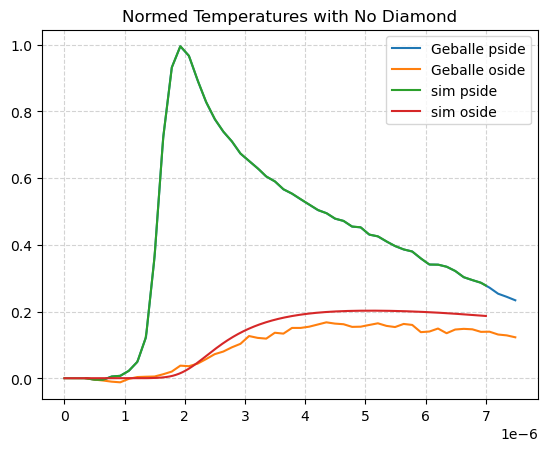

In [17]:
from io_utilities.xdmf_extract import *

time, data = extract_point_timeseries_xdmf(
    os.path.join(save_folder, 'solution.xdmf'),
    function_name='Temperature (K)',
    query_points=[(bx_ir_pside, 0), (BX_ir_oside, 0)]
)

sim_df = pd.DataFrame({'time': time,
                       'pside': data[0],
                       'oside': data[1]})

sim_df['normed pside'] = (sim_df['pside'] - sim_df['pside'].iloc[0]) / (sim_df['pside'].max() - sim_df['pside'].min())
sim_df['normed oside'] = (sim_df['oside'] - sim_df['oside'].iloc[0]) / (sim_df['pside'].max() - sim_df['pside'].min())

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_title('Normed Temperatures with No Diamond')
ax.plot(df_exact['time'], df_exact['pside normed'], label='Geballe pside')
ax.plot(df_exact['time'], df_exact['oside normed'], label='Geballe oside')
ax.plot(sim_df['time'], sim_df['normed pside'], label='sim pside')
ax.plot(sim_df['time'], sim_df['normed oside'], label='sim oside')
ax.grid(True, ls = '--', color = 'lightgray')

ax.legend()
plt.show()


In [18]:
max(sim_df['normed oside'] - max(df_exact['oside normed']))

0.0349735663656586

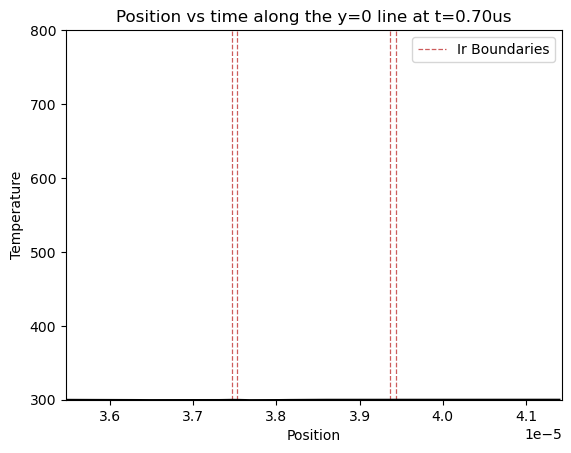

In [19]:

query_points = []
xmin = bx_ir_pside - 2e-6
xmax = BX_ir_oside + 2e-6
samples = 200

for x in np.linspace(xmin, xmax, samples):
    query_points.append((x, 0.0))

time, data = extract_point_timeseries_xdmf(
    os.path.join(save_folder, 'solution.xdmf'),
    function_name='Temperature (K)',
    query_points=query_points
)
locations = np.arange(data.shape[0])

sim_df = pd.DataFrame(data, index=locations.astype(int), columns=time)

fig, ax = plt.subplots()

t0 = 40
location_series = (locations/samples) * (xmax - xmin) + xmin
ymin = 300
ymax = 800

ax.plot(location_series, sim_df.iloc[:, t0], zorder = 3, color = 'black')
ax.vlines([BX_sample, bx_sample, bx_ir_pside, BX_ir_oside], ymin=ymin, ymax=ymax, ls='--', label='Ir Boundaries', color='indianred', zorder=2, lw=0.9)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_xlabel('Position')
ax.set_ylabel('Temperature')
ax.set_title(f'Position vs time along the y=0 line at t={t0*dt*1e6:.2f}us')
ax.legend()
plt.show()
